In [26]:
import io
import os
import zipfile
import pickle
from urllib.request import urlopen
from urllib.parse import urlparse

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [27]:
def summation_score(classifier, weight):
   classifier[classifier > 0] *= weight
   try:
      score = sum(classifier) / len(classifier)
      return score
   except:
      return np.nan


In [28]:
with open('climatebert_parameters.pkl', 'rb') as f:
    parameters = pickle.load(f)

In [29]:
data = pd.read_csv('climatebert_speeches.csv')
unweighted_scores = [summation_score(parameters[key], 1) for key in parameters.keys()]

data['unweighted_scores'] = unweighted_scores
data['probability_score'] = 0.5*(data['unweighted_scores'] + 1)

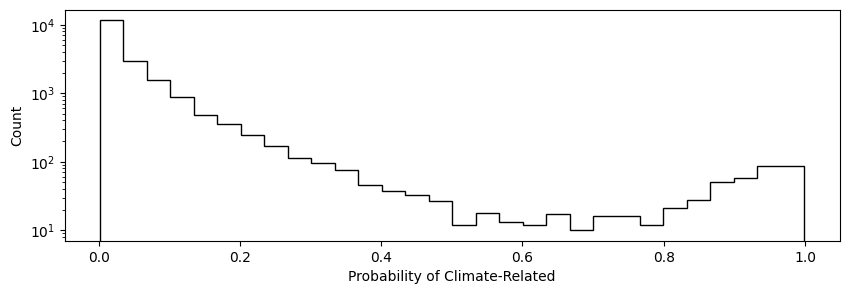

In [30]:
plt.figure(figsize=(10,3))
plt.hist(data['probability_score'], color = 'k', histtype='step', bins=30)
plt.xlabel('Probability of Climate-Related')
plt.ylabel('Count')
plt.yscale('log')

In [31]:
climate_mask = np.all([data['probability_score'] > 0.5], axis=0)
print(f'no. climate-related: {len(data[climate_mask])}')

no. climate-related: 458
